# Lab 5: Transfer learning.

Thanks to their capability to learn generalizable descriptors directly from images, deep Convolutional Neural Networks (CNNs) seem the ideal solution to most pattern recognition problems. On the other hand, to learn the image representation, CNNs need huge sets of annotated samples that are unfeasible in many every-day scenarios. This is the case, for example, of Computer-Aided Diagnosis (CAD) systems for digital pathology, where additional challenges are
posed by the high variability of the cancerous tissue characteristics. 
In this notebooks you are going to implement 4 different training paradigms leveraging CNNs:


1.   Training from scratch
2.   Features extractor followed by SVM
3.   Fine tuning




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import and settings

In [2]:
import os
import cv2
import glob
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

In [3]:
!git clone https://github.com/frpnz/dataset-BIOSTEC2018.git
ROOTDIR_DATASET = "/content/dataset-BIOSTEC2018/crc_images"
IMAGE_SIZE = 32
NUM_CLASSES = 3

Cloning into 'dataset-BIOSTEC2018'...
remote: Enumerating objects: 13518, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 13518 (delta 1), reused 6 (delta 1), pack-reused 13512
Receiving objects: 100% (13518/13518), 1.87 GiB | 39.22 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (13501/13501), done.


## Utils

In [4]:
def seaborn_cm(cm, ax, tick_labels, fontsize=14, title=None, sum_actual="over_columns",
               xrotation=0, yrotation=0):
    """
    Function to plot a confusion matrix
    """
    from matplotlib import cm as plt_cmap
    group_counts = ["{:0.0f}".format(value) for value in cm.flatten()]
    if sum_actual == "over_columns":
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    elif sum_actual == "over_rows":
        cm = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis]
    else:
        print("sum_actual must be over_columns or over_rows")
        exit()
    cm = np.nan_to_num(cm)
    mean_acc = np.mean(np.diag(cm)[cm.sum(axis=1) != 0])
    std_acc = np.std(np.diag(cm))
    group_percentages = ["{:0.0f}".format(value*100) for value in cm.flatten()]
    cm_labels = [f"{c}\n{p}%" for c, p in zip(group_counts, group_percentages)]
    cm_labels = np.asarray(cm_labels).reshape(len(tick_labels), len(tick_labels))
    sns.heatmap(cm,
                ax=ax,
                annot=cm_labels,
                fmt='',
                cbar=False,
                cmap=plt_cmap.Greys,
                linewidths=1, linecolor='black',
                annot_kws={"fontsize": fontsize},
                xticklabels=tick_labels,
                yticklabels=tick_labels)
    ax.set_yticklabels(ax.get_yticklabels(), size=fontsize, rotation=yrotation)
    ax.set_xticklabels(ax.get_xticklabels(), size=fontsize, rotation=xrotation)
    if title:
        title = f"{title}\nMean accuracy {mean_acc * 100:.1f} +- {std_acc * 100:.1f}"
    else:
        title = f"Mean accuracy {mean_acc * 100:.1f} +- {std_acc * 100:.1f}"
    ax.set_title(title)
    if sum_actual == "over_columns":
        ax.set_ylabel("Actual")
        ax.set_xlabel("Predicted")
    else:
        ax.set_ylabel("Predicted")
        ax.set_xlabel("Actual")
    ax.axis("off")

# Assignment #1: create two tensorflow dataset for train and test.
Leverage the API [tf.keras.utils.image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory).

In [5]:
train_dir = os.path.join(ROOTDIR_DATASET, 'train')
test_dir = os.path.join(ROOTDIR_DATASET, 'test')

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=32,
                                                            image_size=(IMAGE_SIZE,IMAGE_SIZE))

test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            shuffle=True,
                                                            batch_size=32,
                                                            image_size=(IMAGE_SIZE,IMAGE_SIZE))

Found 9000 files belonging to 3 classes.
Found 4500 files belonging to 3 classes.


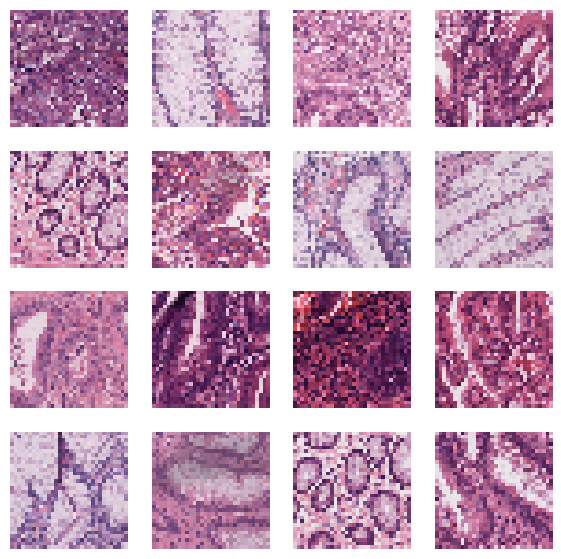

In [6]:
j = 0
fig, ax = plt.subplots(4, 4, figsize=(7, 7))
ax = ax.ravel()
for batch in train_ds.take(1):
    images = batch[0]
    labels = batch[1]
    for image, label in zip(images, labels):
        if j >= 16:
            break
        image = image.numpy().astype(np.uint8)
        ax[j].imshow(image)
        ax[j].axis("off")
        j += 1

# Assignment #2: dataset preparation
1.   Normalize images in the range [0, 1]
2.   Prepare the input pipeline via tf.data.Dataset methods



In [7]:
def process_data(image, label):
    return tf.cast(image, tf.float32) / 255. , tf.one_hot(label, NUM_CLASSES, name='label', axis=-1)

train_ds = train_ds.map(process_data, num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(process_data, num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)

# Assignment #3: train a VGG16 from scratch for 50 epochs

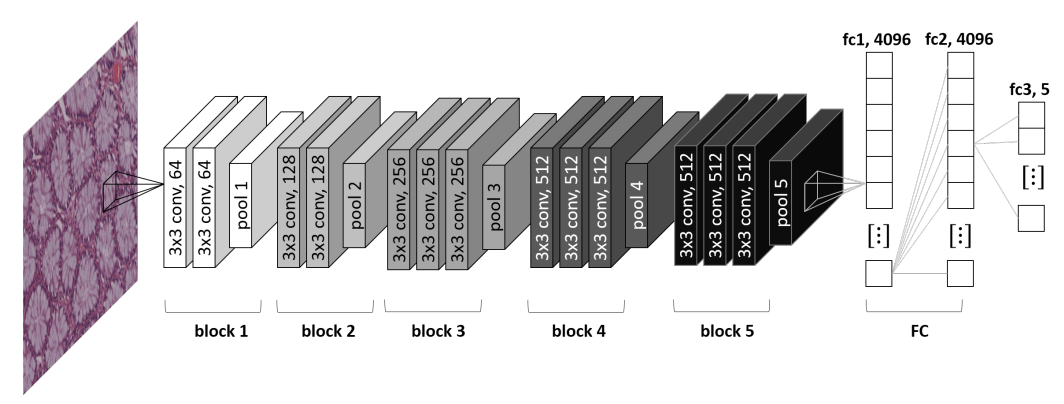

In [8]:
vgg16 = tf.keras.applications.VGG16(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    pooling=None,
    classes=NUM_CLASSES,
    classifier_activation="softmax",
)

vgg16.summary()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
vgg16.compile(optimizer = optimizer, loss="categorical_crossentropy", metrics="accuracy")

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [9]:
def scheduler(epoch, lr):
    if epoch < 45:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [10]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = vgg16.fit(train_ds, epochs=50, callbacks = [callback])

#aumentando le epoche si ha una accuracy più precisa

Epoch 1/50
282/282 [==============================] - 62s 169ms/step - loss: 1.0984 - accuracy: 0.3438 - lr: 0.0100
Epoch 2/50
282/282 [==============================] - 9s 32ms/step - loss: 1.0978 - accuracy: 0.3447 - lr: 0.0100
Epoch 3/50
282/282 [==============================] - 10s 35ms/step - loss: 1.0959 - accuracy: 0.4044 - lr: 0.0100
Epoch 4/50
282/282 [==============================] - 9s 33ms/step - loss: 1.0869 - accuracy: 0.5628 - lr: 0.0100
Epoch 5/50
282/282 [==============================] - 9s 31ms/step - loss: 1.0095 - accuracy: 0.6068 - lr: 0.0100
Epoch 6/50
282/282 [==============================] - 10s 34ms/step - loss: 0.8132 - accuracy: 0.6283 - lr: 0.0100
Epoch 7/50
282/282 [==============================] - 9s 33ms/step - loss: 0.6882 - accuracy: 0.6919 - lr: 0.0100
Epoch 8/50
282/282 [==============================] - 8s 30ms/step - loss: 0.6094 - accuracy: 0.7284 - lr: 0.0100
Epoch 9/50
282/282 [==============================] - 9s 31ms/step - loss: 0.5486 - 

## Plot train loss and accuracy among epochs (see [History](tf.keras.callbacks.History) object) 

In [11]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 282}

Text(0.5, 1.0, 'Loss')

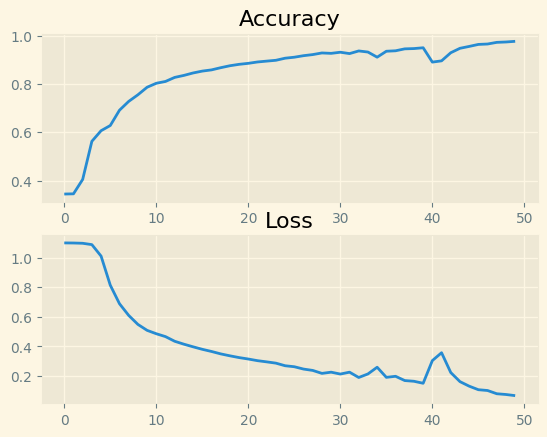

In [12]:
plt.style.use("Solarize_Light2")
fig, ax = plt.subplots(2, 1)
ax[0].plot([e for e in range(history.params['epochs'])], history.history['accuracy'])
ax[0].set_title('Accuracy')
ax[1].plot([e for e in range(history.params['epochs'])], history.history['loss'])
ax[1].set_title('Loss')

# Assignment #4: extract features from VGG16 pre-trained on ImageNet and then train and test a downstream SVM.

Pipeline:
1. Features extraction from the CNN
2. PCA
3. SVM training and test

N.B. Do not shuffle train and test in order to extract labels in the correct order.

In [25]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(ROOTDIR_DATASET, "train"),
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(ROOTDIR_DATASET, "test"),
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 9000 files belonging to 3 classes.
Found 4500 files belonging to 3 classes.


In [26]:
def process_data(image, label):
    image = tf.cast(image, tf.float32)
    return tf.keras.applications.vgg16.preprocess_input(image), label

train_ds = train_ds.map(process_data, num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(process_data, num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)

In [27]:
vgg16 = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    pooling='avg',
    classes=NUM_CLASSES,
    classifier_activation='softmax',
)

58889256/58889256 [==============================] - 0s 0us/step


In [28]:
features_train = vgg16.predict(train_ds)
features_test = vgg16.predict(test_ds)

141/141 [==============================] - 26s 183ms/step


In [29]:
labels_train = np.concatenate([np.argmax(y, axis=1) for _, y in train_ds], axis=0)
labels_test = np.concatenate([np.argmax(y, axis=1) for _, y in test_ds], axis=0)

In [30]:
features_train.shape

(9000, 512)

In [31]:
pca = PCA()
features_train_pca = pca.fit_transform(features_train)
features_test_pca = pca.transform(features_test)

## Exaplained variance

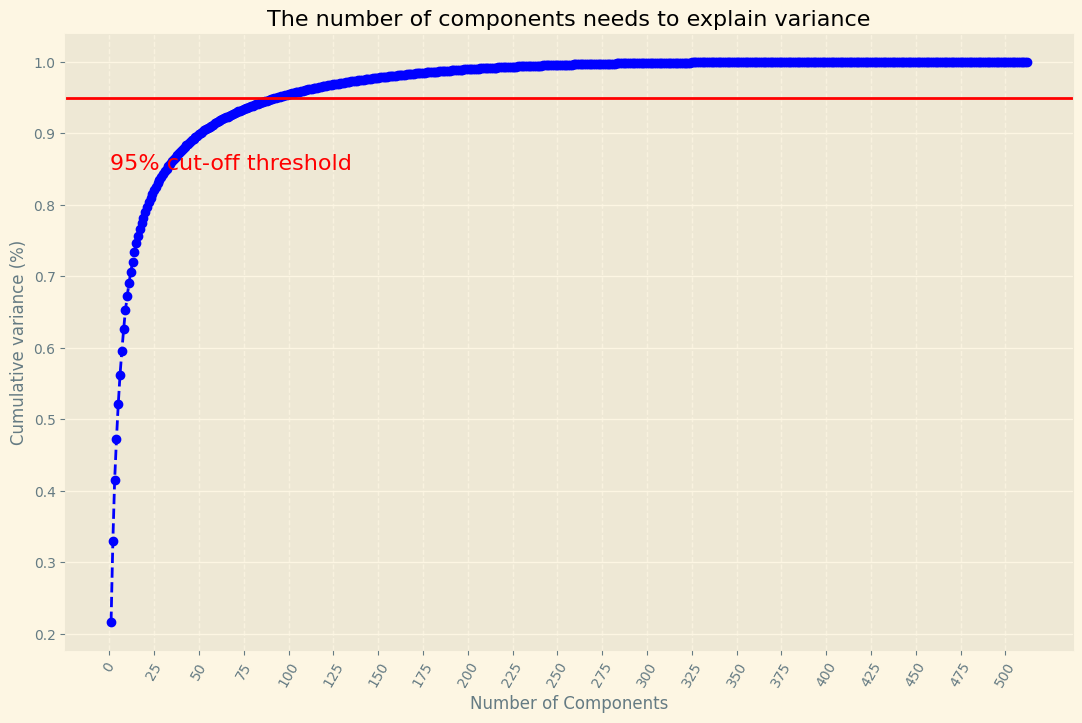

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(13, 8))
xi = np.arange(1, features_train_pca.shape[1] + 1, step=1)
y = pca.explained_variance_ratio_.cumsum()

ax.plot(xi, y, marker='o', linestyle='--', color='b')

ax.set_xlabel('Number of Components')
ax.set_xticks(np.arange(0, features_train_pca.shape[1] + 1, step=25))
ax.set_xticklabels(np.arange(0, features_train_pca.shape[1] + 1, step=25), rotation=60)
ax.set_ylabel('Cumulative variance (%)')
ax.set_title('The number of components needs to explain variance')

ax.axhline(y=0.95, color='r', linestyle='-')
ax.text(0.5, 0.85, '95% cut-off threshold', color='red', fontsize=16)
ax.grid(
    axis='x', 
    alpha=0.75, 
    linestyle='--',
    )

In [33]:
# Actually apply PCA now
pca = PCA(100)
features_train_pca = pca.fit_transform(features_train)
features_test_pca = pca.transform(features_test)

In [34]:
from sklearn.svm import SVC
clf = SVC()
random_grid_svm = {
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto', 0.0001, 0.001, 0.01, 0.1],
    'class_weight': [None, 'balanced'],
    'C': [0.01, 0.1, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
}
search = RandomizedSearchCV(
  estimator=SVC(),
  param_distributions=random_grid_svm,
  scoring='balanced_accuracy',
  n_iter=10,
  cv=3,
  verbose=1,
  random_state=42,
  n_jobs=-1
)
search.fit(features_train_pca, labels_train)
classifier = search.best_estimator_
classifier

Fitting 3 folds for each of 10 candidates, totalling 30 fits


SVC(C=50)

In [36]:
predictions = classifier.predict(features_test_pca)
cm = confusion_matrix(labels_test, predictions)
print('Confusion matrix:\n', cm)

from sklearn.metrics import classification_report
print(classification_report(labels_test, predictions))

Confusion matrix:
 [[1254   55  191]
 [ 151 1342    7]
 [ 127   73 1300]]
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1500
           1       0.91      0.89      0.90      1500
           2       0.87      0.87      0.87      1500

    accuracy                           0.87      4500
   macro avg       0.87      0.87      0.87      4500
weighted avg       0.87      0.87      0.87      4500



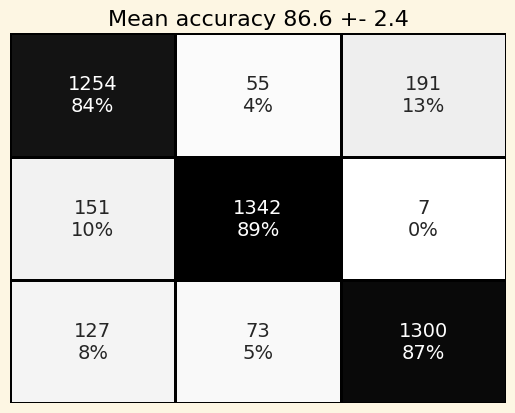

In [35]:
fig, ax=plt.subplots(1,1)
pred_test=classifier.predict(features_test_pca)
cm=confusion_matrix(labels_test,pred_test,labels=[0,1,2])
seaborn_cm(cm,ax,[0,1,2])

# Assignment #5: Fine tune the VGG16 pre-trained on ImageNet.

In [37]:
train_dir = os.path.join(ROOTDIR_DATASET, 'train')
test_dir = os.path.join(ROOTDIR_DATASET, 'test')

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            image_size=(IMAGE_SIZE,IMAGE_SIZE))

test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            shuffle=True,
                                                            batch_size=32,
                                                      label_mode='categorical',
                                                            image_size=(IMAGE_SIZE,IMAGE_SIZE))

Found 9000 files belonging to 3 classes.
Found 4500 files belonging to 3 classes.


In [38]:
def process_data(image, label):
    image = tf.cast(image, tf.float32)
    return  tf.keras.applications.vgg16.preprocess_input(image), label

train_ds = train_ds.map(process_data, num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(process_data, num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)

In [39]:
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), pooling='avg')
x = base_model.output
x = tf.keras.layers.Dense(4096, activation='relu')(x)
x = tf.keras.layers.Dense(4096, activation='relu')(x)
predictions = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers[:10]:
   layer.trainable = False
for layer in base_model.layers[10:]:
   layer.trainable = True



In [40]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics='accuracy')

model.fit(train_ds, epochs=20)

Epoch 1/20
282/282 [==============================] - 34s 111ms/step - loss: 0.7230 - accuracy: 0.7467
Epoch 2/20
282/282 [==============================] - 7s 24ms/step - loss: 0.3653 - accuracy: 0.8617
Epoch 3/20
282/282 [==============================] - 7s 24ms/step - loss: 0.3040 - accuracy: 0.8869
Epoch 4/20
282/282 [==============================] - 7s 25ms/step - loss: 0.2700 - accuracy: 0.9003
Epoch 5/20
282/282 [==============================] - 7s 24ms/step - loss: 0.2466 - accuracy: 0.9078
Epoch 6/20
282/282 [==============================] - 7s 25ms/step - loss: 0.2289 - accuracy: 0.9154
Epoch 7/20
282/282 [==============================] - 7s 25ms/step - loss: 0.2147 - accuracy: 0.9209
Epoch 8/20
282/282 [==============================] - 7s 25ms/step - loss: 0.2028 - accuracy: 0.9244
Epoch 9/20
282/282 [==============================] - 8s 27ms/step - loss: 0.1926 - accuracy: 0.9290
Epoch 10/20
282/282 [==============================] - 7s 25ms/step - loss: 0.1835 - accu

In [41]:
model.evaluate(test_ds)

141/141 [==============================] - 16s 103ms/step - loss: 0.3495 - accuracy: 0.8764


[0.3494885265827179, 0.8764444589614868]